# **CSC461: Final Project**
## <u>Team Members:</u> *Javier Sin & Nicolás Pelegrín*
---

## 0. Data import and visualization

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
sns.set_style('darkgrid')

C:\Users\JVS\AppData\Local\Temp\ipykernel_2924\3755578945.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Dataset including 50k IMDB reviews for sentiment analysis. There's two columns: the first one is the reviews themselves and the second one is the sentiment of the review ('negative' || 'positive').

In [2]:
df_review = pd.read_csv("IMDB Dataset.csv")
df_review

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


## 1. Metrics

Now we'll cite the [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics) we'll be using during the project:
* [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
* [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score)


* **Accuracy**: should be used when the classes are relatively balanced. If the dataset is imbalanced, accuracy can be misleading because the model may simply predict the majority class more often.
* **F1 score**: is the weighted average of precision and recall. It takes both false positives and false negatives into account. It is a better measure than accuracy for imbalanced datasets (not the case).
* **ROC-AUC**: this is a good metric for binary classification problems such us this one. It plots the true positive rate against the false positive rate. It is a good metric to use when the classes are imbalanced.

In this case, as we're going to use balanced datasets, we'll be using <u>accuracy</u> as our main metric. We'll also be using the <u>F1 score</u> to have a better understanding of the model's performance.

We're also going to define a **Panda's Dataframe** so that we can store the results obtained for each model in order to compare them at the end of this notebook.

In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, confusion_matrix

df = pd.DataFrame() # Global variable with the table storing the results of the models

def add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, method, comments):
    # Modifying a global variable inside a function must be done explicitly
    global df

    df_aux = pd.DataFrame(
        {
          "Method"    : [method],
          # "R2_train"  : [r2_score(y_train, y_train_prediction)],
          # "R2_test"   : [r2_score(y_test, y_test_prediction)],
          "accuracy_train" : [accuracy_score(y_train, y_train_prediction)],
          "accuracy_test" : [accuracy_score(y_test, y_test_prediction)],
          # "precision_train" : [precision_score(y_train, y_train_prediction)],
          # "precision_test" : [precision_score(y_test, y_test_prediction)],
          # "recall_train" : [recall_score(y_train, y_train_prediction)],
          # "recall_test" : [recall_score(y_test, y_test_prediction)],
          "f1_train" : [f1_score(y_train, y_train_prediction, pos_label='positive')],
          "f1_test" : [f1_score(y_test, y_test_prediction, pos_label='positive')],
          # "precision_recall_curve_train" : [precision_recall_curve(y_train, y_train_prediction)],
          # "precision_recall_curve_test" : [precision_recall_curve(y_test, y_test_prediction)],
          # "roc_auc_train" : [roc_auc_score(y_train, y_train_prediction)],
          # "roc_auc_test" : [roc_auc_score(y_test, y_test_prediction)],
          # "confusion_matrix_train" : [confusion_matrix(y_train, y_train_prediction)],
          # "confusion_matrix_test" : [confusion_matrix(y_test, y_test_prediction)],
          # "RMSE_train": [mean_squared_error(y_train, y_train_prediction, squared = False)],
          # "RMSE_test" : [mean_squared_error(y_test, y_test_prediction, squared = False)],
          "Comments": [comments]
        }
    )

    df = pd.concat([df, df_aux], ignore_index=True)
    return df_aux

---
## 2. Preparing the data

Now we'll prepare the data for the models. First we'll split the data into training and testing sets. Then we'll use the `TfidfVectorizer` to convert the text data into a matrix of TF-IDF features, which will be used as input for the models.

In [4]:
from sklearn.model_selection import train_test_split

X = df_review['review']
y = df_review['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train.value_counts() # Checking the balance of the classes

sentiment
negative    20039
positive    19961
Name: count, dtype: int64

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

In [6]:
print(X_train.shape)
print(X_train_vect.shape)

(40000,)
(40000, 92692)


## 3. Models to be used

Our goal is to create and tune all the models in order to compare which one is the best for this particular dataset. Instead of just creating the default models and using the only one with best accuracy, we're going to tune them all and compare the results.

### 3.1: Decision Tree

The first model we're going to test is the [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier).

#### 3.1.1: Model creation

In [7]:
# Import the Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

In [8]:
# Create the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Train the model
dt.fit(X_train_vect, y_train)

# Predict the training set
y_train_prediction = dt.predict(X_train_vect)

# Predict the test set
y_test_prediction = dt.predict(X_test_vect)


In [9]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Decision Tree", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,1.0,0.7265,1.0,0.726363,Default parameters


As you can see, the current model with the default parameters suffers from `overfitting`. This can be deduced from the accuracy and f1 scores of 1.0 for the train sets. This means that the model is memorizing the training data patters and not generalizing well to the test data. We can solve this by tuning the hyperparameters of the model, and if this wouldn't be enough, we could also use some regularization techniques like `pruning`.

#### 3.1.2: Model tuning

Now we'll tune the model in order to avoid overfitting so that we can obtain better results.

In [ ]:
# Define the parameter grid
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

# Create the Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=42)

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_dt = grid_search.best_estimator_

# Train the model with the best parameters
best_dt.fit(X_train_vect, y_train)

# Predict the training set
y_train_prediction = best_dt.predict(X_train_vect)

# Predict the test set
y_test_prediction = best_dt.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.801775
Test Accuracy: 0.7434


In [21]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 2}


Now I'll define a range of hyperparameters, for example for `max_depth` in order to see the different results in a plot to view how the model behaves and determine if it suffers from overfitting.

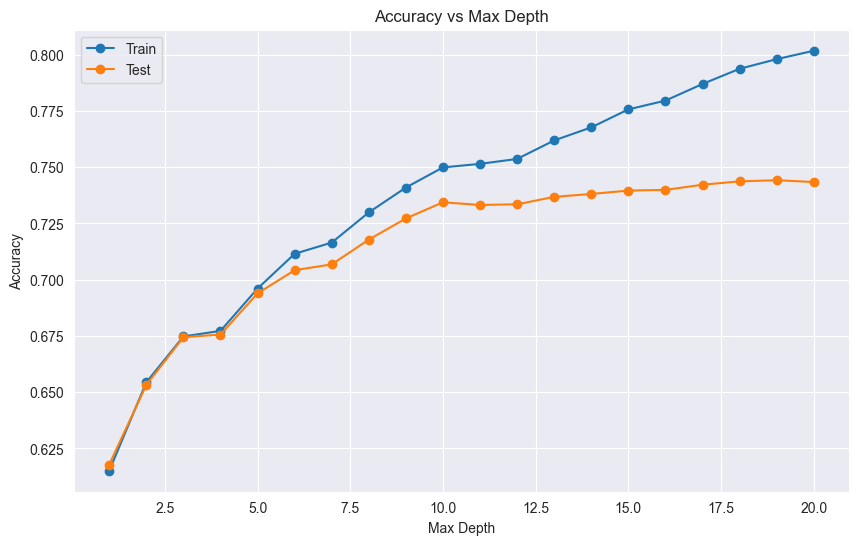

In [16]:
max_depths = range(1, 21)

train_accuracies = []
test_accuracies = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=10, min_samples_split=2, random_state=42)
    dt.fit(X_train_vect, y_train)
    y_train_prediction = dt.predict(X_train_vect)
    y_test_prediction = dt.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_accuracies, marker='o', label='Train')
plt.plot(max_depths, test_accuracies, marker='o', label='Test')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Max Depth')
plt.legend()
plt.show()

We have decided to cap the `max_depth` at 20 as the improvement is minimal after that point. Here's a summary of a test we did increasing the `max_depth` up to 30:

Max Depth: 18 - Train Acc: 0.79375 - Test Acc: 0.7437<br>
Max Depth: 19 - Train Acc: 0.798025 - Test Acc: 0.7442<br>
Max Depth: 20 - Train Acc: 0.801775 - Test Acc: 0.7434<br>
Max Depth: 21 - Train Acc: 0.803725 - Test Acc: 0.7424<br>
Max Depth: 22 - Train Acc: 0.80605 - Test Acc: 0.74<br>
Max Depth: 23 - Train Acc: 0.80945 - Test Acc: 0.7419<br>
Max Depth: 24 - Train Acc: 0.8131 - Test Acc: 0.7436<br>
Max Depth: 25 - Train Acc: 0.8159 - Test Acc: 0.7441<br>
Max Depth: 26 - Train Acc: 0.819375 - Test Acc: 0.7446<br>
Max Depth: 27 - Train Acc: 0.82075 - Test Acc: 0.7438<br>
Max Depth: 28 - Train Acc: 0.82405 - Test Acc: 0.7429<br>
Max Depth: 29 - Train Acc: 0.826275 - Test Acc: 0.7436<br>
Max Depth: 30 - Train Acc: 0.828425 - Test Acc: 0.7454<br>

As you can see, the model just improves in the train set for 0.02 in terms of accuracy, and the test set remains almost the same. Due to this along with the computation time required when increasing the `max_depth`, we decided to cap it at 20. 

In [10]:
best_dt_model = DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=2, random_state=42)
best_dt_model.fit(X_train_vect, y_train)

y_train_prediction = best_dt_model.predict(X_train_vect)
y_test_prediction = best_dt_model.predict(X_test_vect)

add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Decision Tree", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,0.801775,0.7434,0.813457,0.759422,Best parameters found by GridSearchCV


Regarding at the results, this time we see that the **model is not overfitting anymore**, as the accuracy and f1 scores are quite similar for the train and test sets. This means that the model is generalizing well to the test data.

### 3.2: Naive Bayes

The second model we're going to test is the [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB).

Note that even though the classification is a binary one, we're using the `MultinomialNB` class because it's the one that works best with the `TfidfVectorizer` we're using.

#### 3.2.1: Model creation

In [11]:
# Import the Naive Bayes Classifier
from sklearn.naive_bayes import MultinomialNB

In [12]:
# Create the Naive Bayes Classifier
nb = MultinomialNB()

# Train the model
nb.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = nb.predict(X_train_vect)
y_test_prediction = nb.predict(X_test_vect)

# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Naive Bayes", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Naive Bayes,0.9064,0.8652,0.904975,0.864604,Default parameters


#### 3.2.2: Model tuning

In [53]:
# Find the best alpha using GridSearchCV
param_grid = {
    'alpha': np.linspace(0.1, 1, 20)
}

grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_nb = grid_search.best_estimator_

# Train the model with the best parameters
best_nb.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = best_nb.predict(X_train_vect)
y_test_prediction = best_nb.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")


Train Accuracy: 0.916975
Test Accuracy: 0.864


In [54]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'alpha': 0.4789473684210527}


In [55]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Naive Bayes", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Naive Bayes,0.916975,0.864,0.915909,0.863891,Best parameters found by GridSearchCV


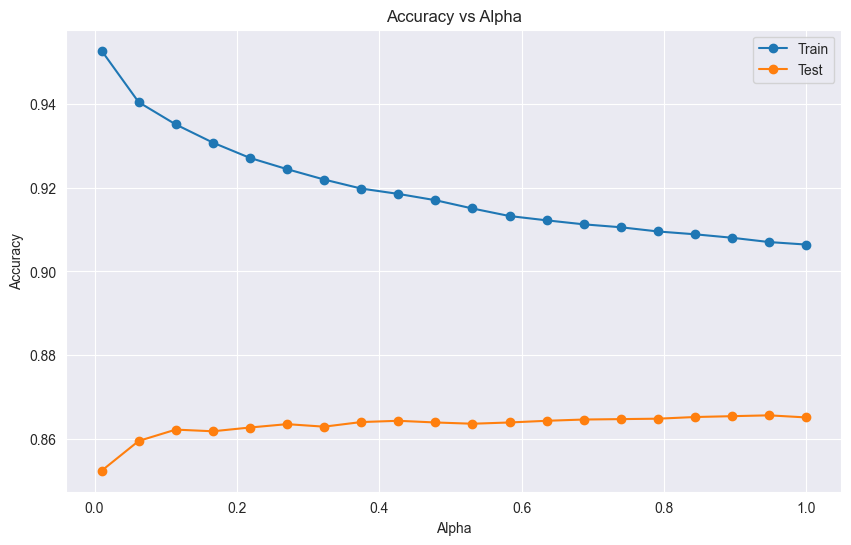

In [52]:
# Plot comparing the evolution of the accuracy for increasing values of alpha
alphas = np.linspace(0.01, 1, 20)

train_accuracies = []
test_accuracies = []

for alpha in alphas:
    nb = MultinomialNB(alpha=alpha)
    nb.fit(X_train_vect, y_train)
    y_train_prediction = nb.predict(X_train_vect)
    y_test_prediction = nb.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(alphas, train_accuracies, marker='o', label='Train')
plt.plot(alphas, test_accuracies, marker='o', label='Test')
plt.xlabel('Alpha')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Alpha')
plt.legend()
plt.show()

In the above plot, we can see that the model's test accuracy doesn't improve drastically after `alpha = 0.1`. However, the best alpha value would be around `0.45` as the GridSearchCV suggests. This can be justified by the fact that in that point, the train accuracy is still high but doesn't overfit the data. Actually, alphas starting at 0.25 would be already good, but the one chosen is the one who gives the best results in the test set. This way, the model will generalize better to unseen data.

### 3.3: Logistic Regression

The third model we're going to test is the [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression).

#### 3.3.1: Model creation

In [18]:
# Import the Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

In [34]:
# Create the Logistic Regression Classifier
lr = LogisticRegression(max_iter=1000)

# Train the model
lr.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = lr.predict(X_train_vect)
y_test_prediction = lr.predict(X_test_vect)

# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Logistic Regression", "Default parameters")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Logistic Regression,0.933475,0.8942,0.933867,0.89668,Default parameters


#### 3.3.2: Model tuning

In the case of Logistic Regression, the most important parameter to tune is the `C` parameter, which is the inverse of the regularization strength. The smaller the value of `C`, the stronger the regularization.

In [69]:
# Find the best C using GridSearchCV
param_grid = {
    'C': np.logspace(-4, 4, 20)
}

grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vect, y_train)

# Get the best estimator
best_lr = grid_search.best_estimator_

# Train the model with the best parameters
best_lr.fit(X_train_vect, y_train)

# Predict the training and test sets
y_train_prediction = best_lr.predict(X_train_vect)
y_test_prediction = best_lr.predict(X_test_vect)

# Evaluate the performance
train_accuracy = accuracy_score(y_train, y_train_prediction)
test_accuracy = accuracy_score(y_test, y_test_prediction)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 0.96765
Test Accuracy: 0.8984


In [70]:
# Print the best configuration of parameters obtained by GridSearchCV
print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

Best parameters found by GridSearchCV:
{'C': 4.281332398719396}


In [71]:
# Add the results to the df
add_to_df(y_train, y_train_prediction, y_test, y_test_prediction, "Logistic Regression", "Best parameters found by GridSearchCV")

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Logistic Regression,0.96765,0.8984,0.967676,0.900353,Best parameters found by GridSearchCV


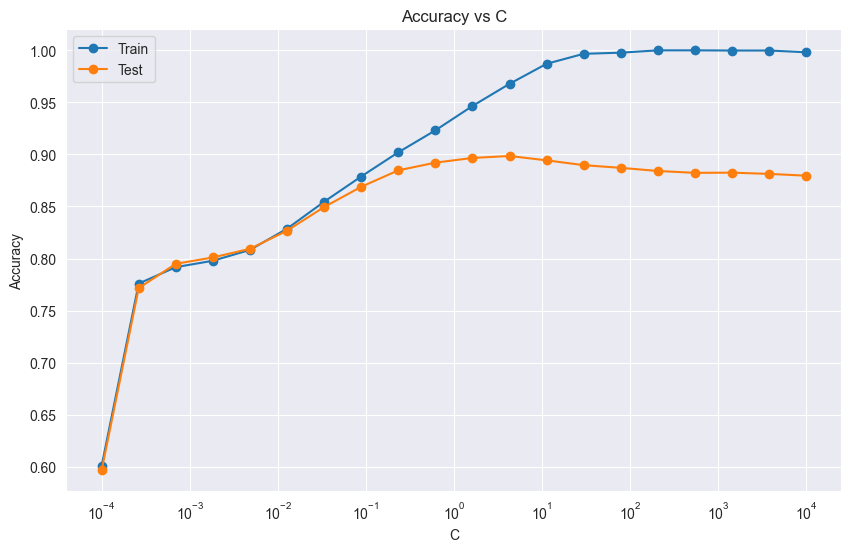

In [19]:
# Plot comparing the evolution of the accuracy for increasing values of C
Cs = np.logspace(-4, 4, 20)

train_accuracies = []
test_accuracies = []

for C in Cs:
    lr = LogisticRegression(C=C, max_iter=1000)
    lr.fit(X_train_vect, y_train)
    y_train_prediction = lr.predict(X_train_vect)
    y_test_prediction = lr.predict(X_test_vect)
    train_accuracy = accuracy_score(y_train, y_train_prediction)
    test_accuracy = accuracy_score(y_test, y_test_prediction)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

plt.figure(figsize=(10, 6))
plt.plot(Cs, train_accuracies, marker='o', label='Train')
plt.plot(Cs, test_accuracies, marker='o', label='Test')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()

plt.xscale('log')
plt.show()

In this plot we can observe the following insights:

1. <u>Low C</u> ($C = 10^{-4}$ to $10^{-2}$): 
    * The training accuracy is very low, indicating **underfitting**. The model is overly simplified and cannot caputre the complexity of the data.
    * Test accuracy also low in this region, showing that it doesn't generalize well.

2. <u>Moderate C</u> ($C = 10^{-1}$ to $C \approx 4.28$):
    * Both training and test accuracies increase as C grows, suggesting the model is better at capturing the data patterns without overfitting.
    * Around C = 4.28, the test accuracy reaches its peak, and the training accuracy is close to the test accuracy, indicating **good generalization**.

3. <u>High C</u> ( $C \gt 4.28$):
    * The training accuracy approaches 100%, indicating **overfitting** (the model fits the training data too closely).
    * The test accuracy plateaus or slightly declines, showing the model's inability to generalize well to unseen data.


## Model testing

In [68]:
testing = vectorizer.transform(["It's really not bad at all. I enjoyed it a lot!"])
print(best_lr.predict(testing))

['positive']


## Model comparison

Print the table with the performance of the models in order to visually see the differences between them.

In [72]:
# Print the dataframe with the results
df

,Method,accuracy_train,accuracy_test,f1_train,f1_test,Comments
0,Decision Tree,0.801775,0.7434,0.813457,0.759422,Best parameters
1,Naive Bayes,0.906400,0.8652,0.904975,0.864604,Default parameters
2,Naive Bayes,0.916450,0.8640,0.915375,0.863837,Best parameters found by GridSearchCV
3,Logistic Regression,0.933475,0.8942,0.933867,0.896680,Default parameters
4,Logistic Regression,0.948200,0.8974,0.948370,0.899668,Best parameters found by GridSearchCV
5,Naive Bayes,0.916975,0.8640,0.915909,0.863891,Best parameters found by GridSearchCV
6,Logistic Regression,0.967650,0.8984,0.967676,0.900353,Best parameters found by GridSearchCV
7,Logistic Regression,0.999950,0.8788,0.999950,0.881037,Best parameters found by GridSearchCV
8,Logistic Regression,0.967650,0.8984,0.967676,0.900353,Best parameters found by GridSearchCV
